## Authors EDA
Exploratory data analysis focused on authors.

In [117]:
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np

%matplotlib inline

In [118]:
%%time

# load metadata extracted data in notebook 00_load_metadata
# parse the author_parsed entries into a list of authors for each paper
arxiv_metadata = pd.read_csv('data/arxiv_metadata.zip', converters={"authors_parsed": lambda x:[entry.strip('[]') for entry in  x.split("], ")]})

<timed exec>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 11.8 s, sys: 754 ms, total: 12.5 s
Wall time: 12.5 s


### Count unique authors
Take the list of "authors_parsed" for each paper. Flatten it. Remove duplicates.

In [119]:
def flatten(xss):
    """Flatten a list of lists"""
    return [x for xs in xss for x in xs]

def get_unique_authors(df):
    """Given a dataframe, return unique authors"""
    authors = flatten(df['authors_parsed'])
    return set(authors)

def count_authors(df):
    """Given a dataframe, return count of unique authors"""
    return len(get_unique_authors(df))

In [120]:
# ALL AUTHORS
count_all_authors = count_authors(arxiv_metadata)

# PUBLISHED AUTHORS
idx = arxiv_metadata['journal-ref'].isna()
arxiv_published = arxiv_metadata[~idx]
count_published_authors = count_authors(arxiv_published)

pd.DataFrame.from_dict(
    {'All authors': count_all_authors, 'Published authors': count_published_authors}, orient='index', columns=["Count"])

,Count
All authors,1918203
Published authors,881061


### Authors by subject

1. Make a dict of papers by subject, if a paper has several subjects, then that's several entries.
2. For each subject, take the count unique authors

In [121]:
keys = ["Computer Science", "Economics", "Electrical Engineering and Systems Science", "Mathematics", "Physics", "Quantitative Biology", "Quantitative Finance", "Statistics", "Junk"]

In [122]:
def count_authors_by_subject(df):
    # Make a dict of papers by subject (a DataFrame for each subject), if a paper has several subjects, then that paper will be in multiple DataFrames.
    papers_by_subject = {key: [] for key in keys}
    for key in keys:
        idx = df[key] == 1
        papers_by_subject[key] = df[idx]
    
    # For each subject, take the count unique authors
    return {key: count_authors(papers_by_subject[key]) for key in keys}

count_all_authors_by_subject = count_authors_by_subject(arxiv_metadata)
count_published_authors_by_subject = count_authors_by_subject(arxiv_published)
authors_by_subject = pd.DataFrame.from_records([count_all_authors_by_subject, count_published_authors_by_subject], index=['All papers', 'Published papers'])
# Rotate the DataFrame
authors_by_subject = authors_by_subject.T
authors_by_subject

,All papers,Published papers
Computer Science,983756,347178
Economics,13603,2051
Electrical Engineering and Systems Science,141277,25873
Mathematics,306731,106396
Physics,1072227,629407
Quantitative Biology,94642,28707
Quantitative Finance,24053,5525
Statistics,139837,32216
Junk,3501,647


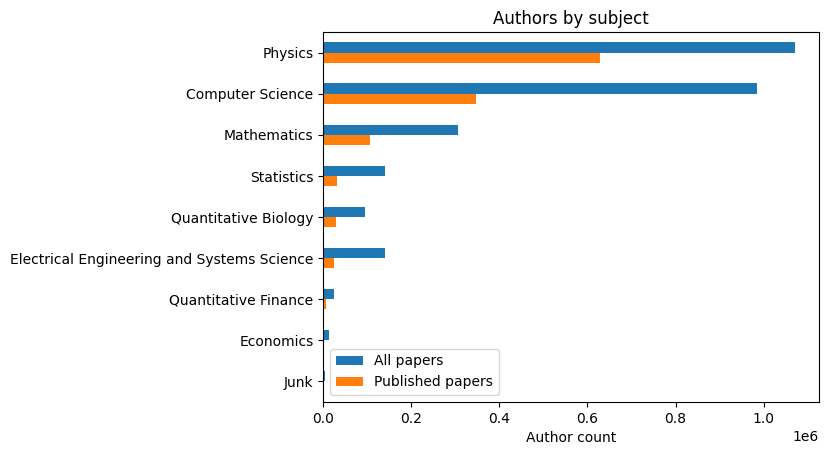

In [124]:
pp_subject = authors_by_subject.sort_values('Published papers', ascending=False)
bar_plot = pp_subject.plot.barh()
bar_plot.set_title('Authors by subject')
bar_plot.set_xlabel('Author count')
bar_plot.invert_yaxis()
plt.show();

### Published authors over time

#### Cumulative number of authors 

In [214]:
# keep only papers 1992 - 2023, as older years are incomplete
min_year = 1992  # arxiv_metadata.year.min()
max_year = 2023  # arxiv_metadata.year.max()

In [215]:
# PUBLISHED
arxiv_published = arxiv_published[(arxiv_published['year'] >= min_year)]
arxiv_published = arxiv_published[(arxiv_published['year'] <= max_year)]

# SUBMITTED (ALL PAPERS)
arxiv_metadata = arxiv_metadata[(arxiv_metadata['year'] >= min_year)]
arxiv_metadata = arxiv_metadata[(arxiv_metadata['year'] <= max_year)]

In [257]:
# AUTHORS PUBLISHED
counts_published = pd.DataFrame(columns=['year', 'month', 'count'])
year = []; month = []; authors_count = []
for entry in arxiv_published.groupby([arxiv_published.year, arxiv_published.month]):
    entry_year = entry[0][0]
    year.append(entry_year)
    entry_month = entry[0][1]
    month.append(entry_month)
    authors_count.append(len(set(flatten(arxiv_published[(arxiv_published['month']==entry_month) & (arxiv_published['year']==entry_year)]['authors_parsed']))))
counts_published['year'] = year
counts_published['month'] = month
counts_published['count'] = authors_count

# ALL AUTHORS
counts_all = pd.DataFrame(columns=['year', 'month', 'count'])
year = []; month = []; authors_count = []
for entry in arxiv_metadata.groupby([arxiv_metadata.year, arxiv_metadata.month]):
    entry_year = entry[0][0]
    year.append(entry_year)
    entry_month = entry[0][1]
    month.append(entry_month)
    authors_count.append(len(set(flatten(arxiv_metadata[(arxiv_metadata['month']==entry_month) & (arxiv_metadata['year']==entry_year)]['authors_parsed']))))
counts_all['year'] = year
counts_all['month'] = month
counts_all['count'] = authors_count

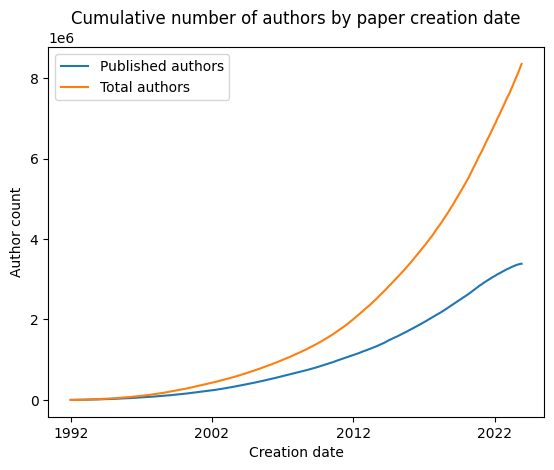

In [259]:
plt.title('Cumulative number of authors by paper creation date')
plt.xticks(ticks=range(0, len(counts_published), 120), labels=range(min_year, max_year+1, 10))
plt.xlabel('Creation date')
plt.ylabel('Author count')
plt.plot(np.cumsum(list(counts_published['count'])), label='Published authors')
plt.plot(np.cumsum(list(counts_all['count'])), label='Total authors')
plt.legend()
plt.show();

### Monthly number of authors by paper creation date

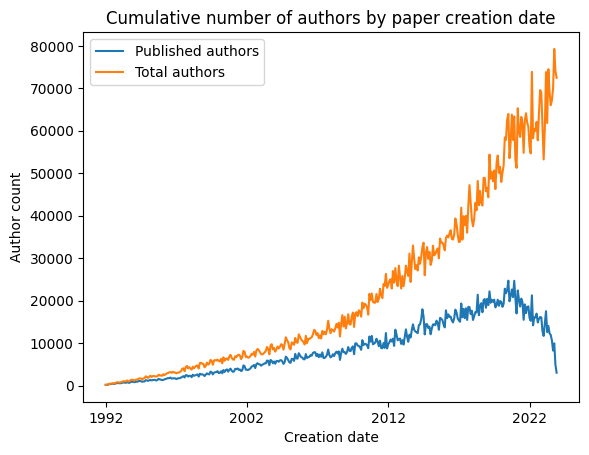

In [260]:
plt.title('Cumulative number of authors by paper creation date')
plt.xticks(ticks=range(0, len(counts_published), 120), labels=range(min_year, max_year+1, 10))
plt.xlabel('Creation date')
plt.ylabel('Author count')
plt.plot(list(counts_published['count']), label='Published authors')
plt.plot(list(counts_all['count']), label='Total authors')
plt.legend()
plt.show();